# Exploration des données

#### Importation des modules nécessaires

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
from progiter import ProgIter
import cv2

import warnings
warnings.simplefilter('ignore')

#### Nettoyage et compilation des différents datasets
1. Création des listes des fichiers à importer
2. Création des liste de diagnostic associé aux fichier
    * 0 correspond aux patients sains
    * 1 correspond aux infections pulmonaires classiques
    * 2 correspond aux pneumonies virales
    * 3 correspond aux infection COVID-19
3. Création des listes indiquant le stockage local du dataset
4. Creation d'une liste des 4 dataframes
5. Création dictionnaire des renommages de colonnes
6. Identifier le nombre de donnée pour chaque fichier et diagnostique

In [4]:
l_label = ["Normal", "Viral_Pneumonia","Lung_Opacity", "COVID"]
l_diag = [0,1,2,3]
l_colour = ['green','orange','yellow', 'red']                          # Creation d'une liste pour uniformiser les codes couleurs
l_path = ['./Datasets/Normal/','./Datasets/Viral_Pneumonia/','./Datasets/Lung_Opacity/','./Datasets/COVID/']


col_name = {'FILE NAME' : 'File',
            'FORMAT' : 'Format',
            'SIZE' : 'Size',
            }
l_count = []
l_df = []
        
for index, diag in zip(range(0,4), l_diag):
            l_df.append(pd.read_excel('./Datasets/'+l_label[index]+ ".metadata.xlsx"))   # Enlister les dataframes
            l_count.append(l_df[index].shape[0])                       # Enlister le nombre d'image de chaque dataframes
            l_df[index] = l_df[index].rename(col_name, axis=1)         # Renommer les colonnes des dataframes
            l_df[index]['Diagnostic'] = diag                           # Creation d'une colonne 'Diagnostic'
            l_df[index]['Path_images'] = l_path[index]                 # Creation d'une colonne contenant le chemin des fichiers images

### Répartition des données pour chaque classes de Diagnostics

Le jeu  Normal  contient  10192  radiographies
Le jeu  Viral_Pneumonia  contient  1345  radiographies
Le jeu  Lung_Opacity  contient  6012  radiographies
Le jeu  COVID  contient  3616  radiographies


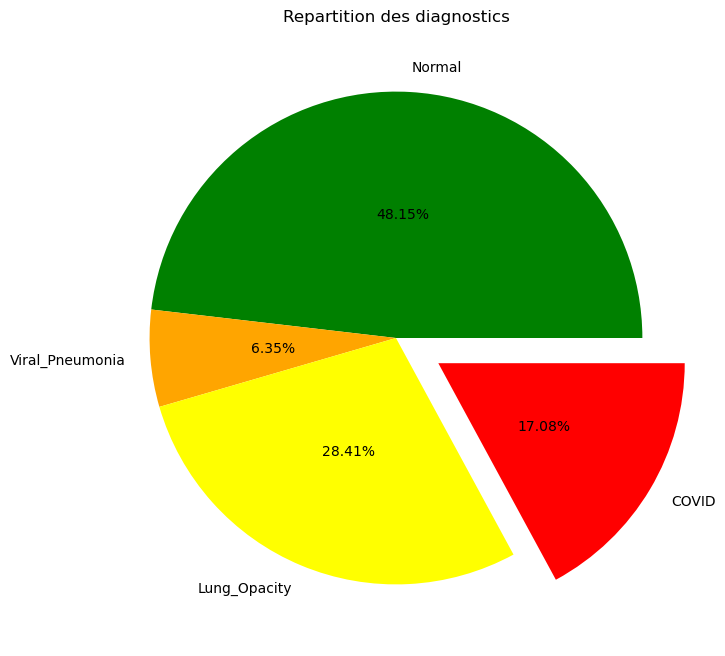

In [5]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(111)
x = [1, 2, 3, 4]
ax1.pie(l_count, labels = l_label, colors = l_colour, explode = [0, 0, 0, 0.2], autopct = lambda x: str(round(x, 2)) + '%', pctdistance = 0.5, labeldistance = 1.1);
ax1.set_title('Repartition des diagnostics');

for index in l_diag:
    print('Le jeu ',l_label[index],' contient ', l_count[index],' radiographies')


<div class="alert alert-info" role="alert">
  Nous remarquons un large desequilibre des jeux de radiographie. Il faudra en tenir compte lors de la selection du jeu d'entrainement ulterieur
</div>

#### selection d'un dataframe global
* Pour l'explorations des données nous travaillerons sur un dataset global
* Les attributs format et size renseignés sont identiques; Donc il est inutile de les conserver

In [6]:
df_radios = pd.concat([l_df[index] for index in range(0,4)], axis = 0, ignore_index=True)
df_radios = shuffle(df_radios, random_state = 69).reset_index()
df_radios = df_radios.drop(['index','Format','Size'],axis=1)            

## Analyse des donnes des Images et des Masques

En analysant  les fichiers d'images et de masques, nous constatons que:
* Toutes les masques sont encodé en mode RGB et avec une taille de 256*256
* 99% des images sont encodé en mode L (Grayscale), seules 140 images du jeu Viral Pneumonia" sont en en mode RBG. La taille des images est de 299*299

<div class="alert alert-info" role="alert">
  Une étape de Preprocessing des masques sera les mettre à la même taille et mode que le images, soit en 299*299 et en mode L. Les masques devront également être mis en 'Grayscale'
</div>

#### Séléctionner et afficher les Images, les masques et leur resultante

In [13]:
img = cv2.imread(df_radios['Path_images'].loc[10]+'masks/'+ df_radios['File'].loc[10]+'.png',
                     cv2.IMREAD_GRAYSCALE)
img.shape

(256, 256)

In [41]:
# Fonction de recuperation des images et du masque
def get_radio(data : pd.core.frame.DataFrame = None, index : int=0) -> (np.ndarray,np.ndarray):
    
    img = cv2.imread(data['Path_images'].loc[index]+'images/'+ data['File'].loc[index]+'.png',
                     cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(data['Path_images'].loc[index]+'masks/'+ data['File'].loc[index]+'.png',
                     cv2.IMREAD_GRAYSCALE)
    msk_r = cv2.resize(msk, img.shape)
    return (img, msk_r)

def apply_mask(image: np.ndarray = None, mask: np.ndarray=None) -> (np.ndarray, list, list):
 
    mskimg_a = mask.astype(int) * image.astype(int)             # Application du masque par Broadcasting
    mskimg_a = np.round(mskimg_a * 255.0 / np.max(mskimg_a),0)  # NORMALISATION

    image_l = mskimg_a.tolist()
    image_fl = []
    image_flze = []

    for i in range(0,len(image_l)):  # transfromation de l'array en liste de d'intensité de 0 à 255
        image_fl += image_l[i]

    for i in np.flatnonzero(image_fl): # liste d'intensité de 1 à 255
        image_flze.append(image_fl[i])
        
    intensite = [image_flze.count(i) for i in range(0,256)] # liste representant la distribution d'intensité non normalisé de l'image
    return (mskimg_a, image_flze, intensite)

tirage_index = np.random.choice(df_radios.index)         #Tirage d'une radio au hasard
radio, masque = get_radio(df_radios, tirage_index)
radio_m, radio_l, radio_d = apply_mask(radio, masque)


#### Afficher les Images, les masques et leur resultante

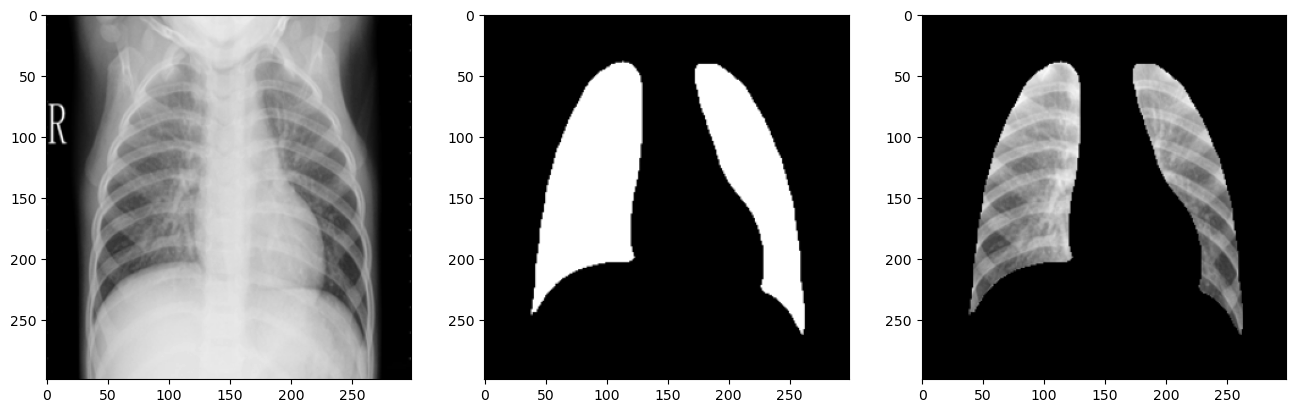

In [42]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(radio, cmap='gray')
ax2.imshow(masque, cmap='gray')
ax3.imshow(radio_m, cmap='gray');

Chaque radio la surface pulmonaire varie en fonction de la taille du patient, et des conditions de prise de la radio. Or dans l'analyse, Seule la surface pulmonaire nous interessera, la quantité de données utiles aux modèle futur pourrait etre reduite à la surface pulmonaire.

<div class="alert alert-info" role="alert">
 Un moyen de caractériser l'image de manière indépendante de la taille des poumons de manière uniforme et la distribution d'intensité de l'image 
</div>

#### Afficher le ratio de surface utile et la distribution d'intensite de l'image

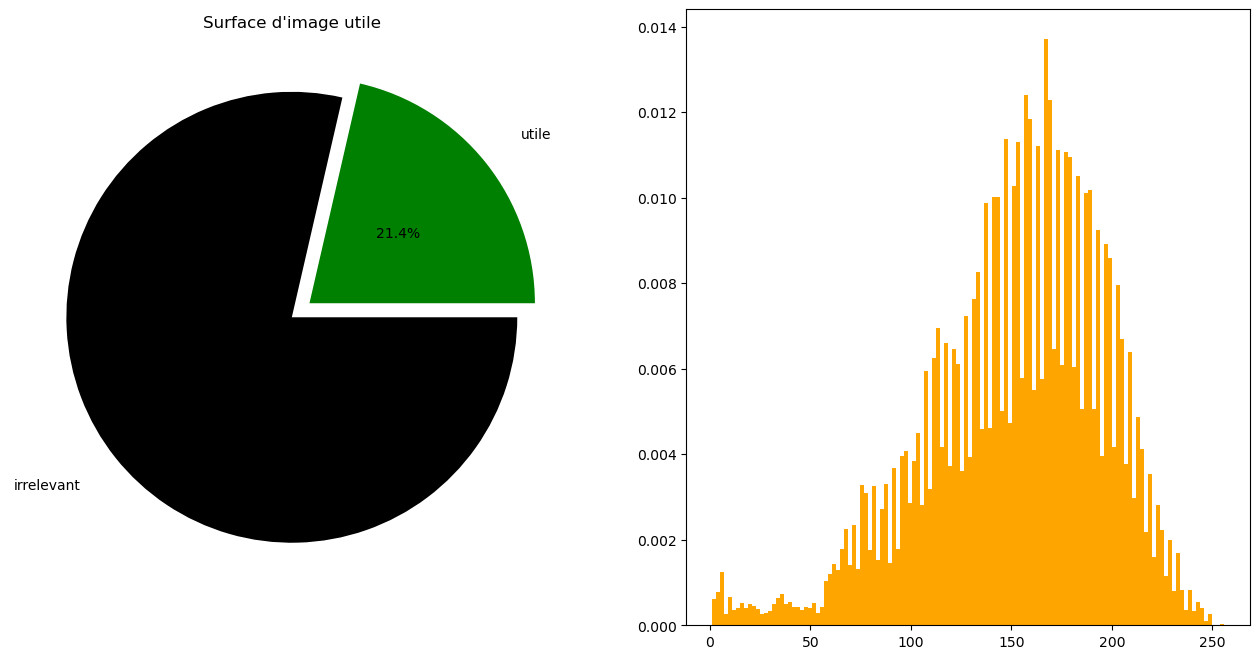

In [43]:
fig = plt.figure(figsize=(16,8))
ax3 = fig.add_subplot(121)
ax4 = fig.add_subplot(122)

pulm = masque.sum()//255
not_pulm = masque.shape[0] * masque.shape[1] - pulm

ax3.pie( [pulm, not_pulm ],
        labels = ['utile','irrelevant'], colors = ['green','black'],explode = [0.1, 0],
        autopct = lambda x: str(round(x, 2)) + '%', pctdistance = 0.5, labeldistance = 1.2);
ax3.set_title('Surface d\'image utile')
ax4.hist(radio_l, bins=128, range = (1,256), density = True, color='orange',rwidth=1);


#### 2. Moyenne des surface pulmonaire
Pour chaque radio la surface pulmonaire varie en fonction de la taille du patient, et des conditions de prise de la radio. Hors dans l'analyse, comme seul la surface pulmonaire nous interessera, la quantité de donnée utile aux modèle futur pourra etre reduite à la surface pulmonaire.
Voyons le ratio de la surface pulmonaire par patient

In [44]:
import asyncio
from tqdm import tqdm

async def lecture(data,index,liste):
    radio, masque = get_radio(data, index)
    pulm = masque.sum()//255
    liste.append(pulm/(masque.shape[0]*masque.shape[1]))  



l_surf_pul = []
for index in ProgIter(range(0,len(df_radios),1)):
    await lecture(df_radios,index,l_surf_pul)  

 100.00% 21165/21165... rate=490.18 Hz, eta=0:00:00, total=0:00:44


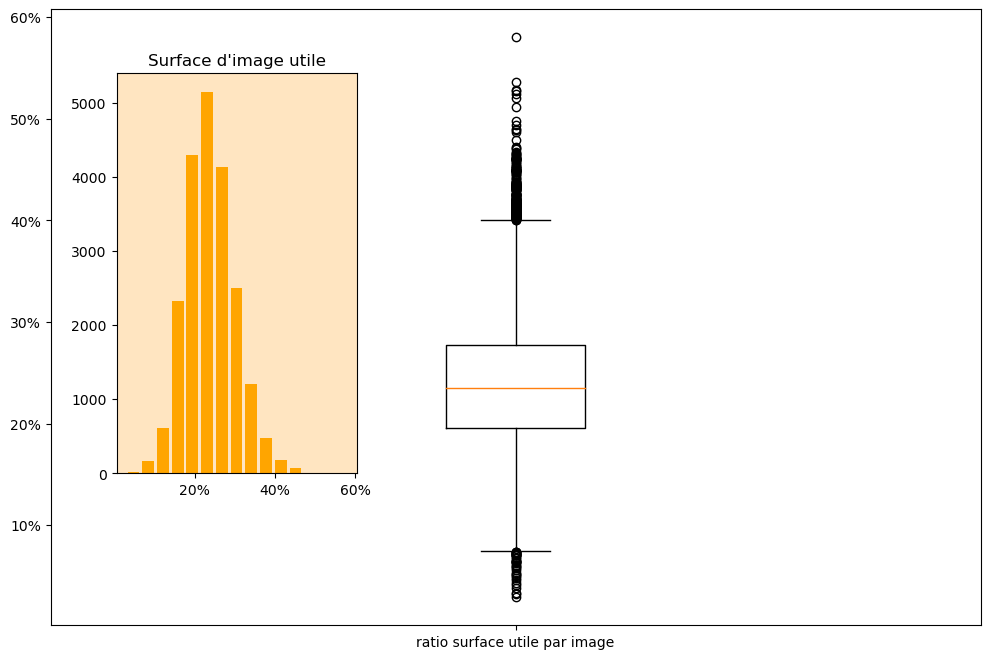

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax4 = plt.axes([0.18, 0.3,0.2, 0.5], facecolor='#ffe5c1')

ax1.boxplot(l_surf_pul)
ticks = ax1.get_yticks()
ax1.set_yticklabels([str(int(ticks[l]*100))+'%' for l in range(0,len(ticks))])
ax1.set_xticklabels(['ratio surface utile par image'])

ax4.hist(l_surf_pul, bins=15, color='orange', rwidth=0.8)
ticks = ax4.get_xticks()

ax4.set_xticklabels([str(int(ticks[l]*100))+'%' for l in range(0,len(ticks))])

ax4.set_title('Surface d\'image utile');

Les masques vont nous permettre de limiter les données transmises au modèle apres le preprocessing.
En moyenne on pourra reduire les données de 75%

### 3. Lecture parrallele au hasard de densité de pixel pour les 4 diagnostics

#### Codage de la fonction d'affichage parallèles

In [46]:
def AffichageAleatoire():
    tirage_index0 = np.random.choice(l_df[0].index)
    tirage_index3 = np.random.choice(l_df[3].index)
    tirage_index2 = np.random.choice(l_df[2].index)
    tirage_index1 = np.random.choice(l_df[1].index)

    radio0, masque0 = get_radio(l_df[0], tirage_index0 )
    radio_m0, radio_l0, radio_d0 = apply_mask(radio0, masque0)

    radio1, masque1 = get_radio(l_df[1], tirage_index1 )
    radio_m1, radio_l1, radio_d1 = apply_mask(radio1, masque1)

    radio2, masque2 = get_radio(l_df[2], tirage_index2 )
    radio_m2, radio_l2, radio_d2 = apply_mask(radio2, masque2)

    radio3, masque3 = get_radio(l_df[3], tirage_index3 )
    radio_m3, radio_l3, radio_d3 = apply_mask(radio3, masque3)
    
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(241)
    ax2 = fig.add_subplot(242)
    ax3 = fig.add_subplot(243)
    ax4 = fig.add_subplot(244)
    ax5 = fig.add_subplot(245)
    ax5.set_ylim([0,0.0250])
    ax6 = fig.add_subplot(246, sharey=ax5)
    ax7 = fig.add_subplot(247, sharey=ax5)
    ax8 = fig.add_subplot(248, sharey=ax5)

    ax1.set_title('Patient Sain: ' + str(tirage_index0))
    ax5.set_title('Patient Sain: '+ str(tirage_index0))
    ax1.imshow(radio_m0, cmap='gray')
    ax5.bar(range(0,256), radio_d0/np.sum(radio_d0)  , color = 'green', width = 1);

    ax2.set_title('Patient Covid ' + str(tirage_index3))
    ax6.set_title('Patient Covid '+ str(tirage_index3))
    ax2.imshow(radio_m3, cmap='gray')
    ax6.bar(range(0,256), radio_d3/np.sum(radio_d3)  , color = 'red', width = 1);

    ax3.set_title('Infection pulmonaire ' + str(tirage_index2))
    ax7.set_title('Infection pulmonaire '+ str(tirage_index2))
    ax3.imshow(radio_m2, cmap='gray')
    ax7.bar(range(0,256), radio_d2/np.sum(radio_d2)  , color = 'yellow', width = 1);

    ax4.set_title('Pneumonie virale '+ str(tirage_index1))
    ax8.set_title('Pneumonie virale '+ str(tirage_index1))
    ax4.imshow(radio_m1, cmap='gray')
    ax8.bar(range(0,256), radio_d1/np.sum(radio_d1)  , color = 'orange', width = 1);



#### Execution

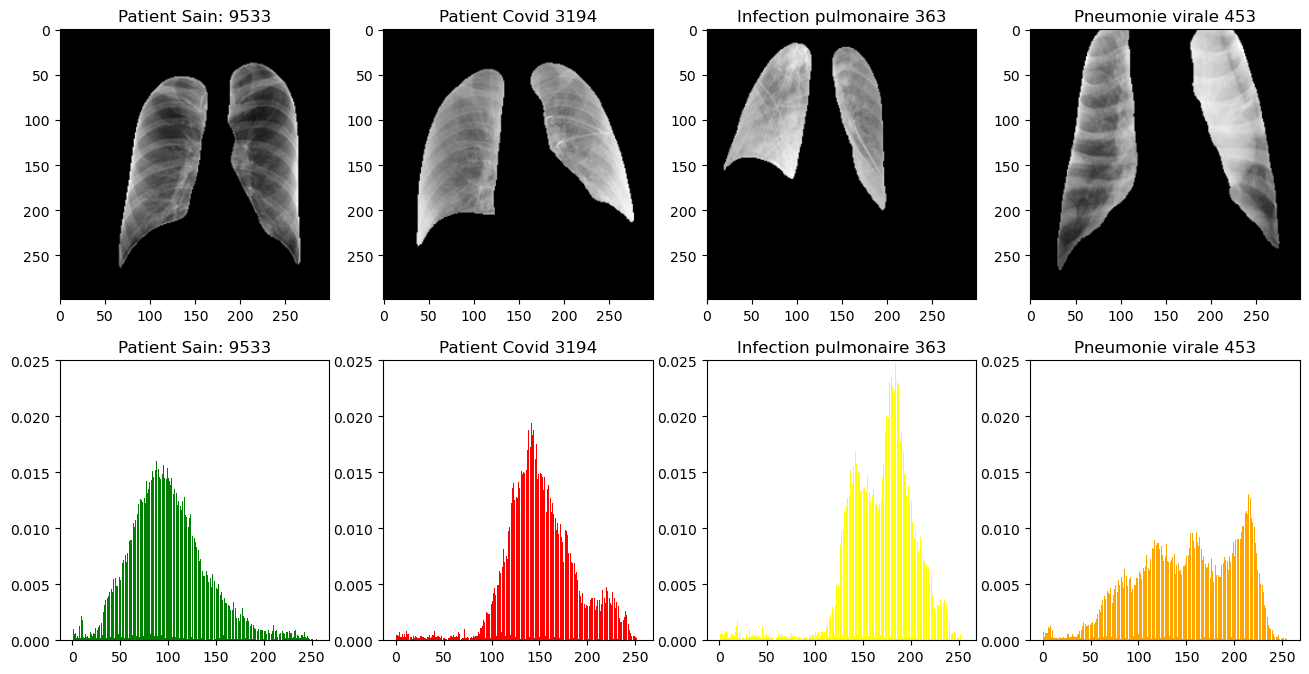

In [51]:
AffichageAleatoire()